In [1]:
# Import necessary packages
import os
import rasterio as rio
import rasterio.mask
import earthpy as et
import fiona
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
tif_data_path = "toyohashi_export_full_scale_smaller.tif"
with rio.open(tif_data_path) as lidar_dem:
    lidar_dem.bounds

In [3]:
lidar_dem.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 1393,
 'height': 1393,
 'count': 3,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(8.98315284119521e-06, 0.0, 137.3124947938014,
        0.0, -8.98315284119521e-06, 34.67500589962489)}

In [4]:
# View image tif_data_path
with rio.open(tif_data_path) as lidar_dem:
    print(lidar_dem.tags(ns='IMAGE_STRUCTURE'))
    lidar_dem_mask = lidar_dem.dataset_mask()

{'COMPRESSION': 'LZW', 'INTERLEAVE': 'PIXEL'}


In [5]:
lidar_dem.bounds

BoundingBox(left=137.3124947938014, bottom=34.66249236771711, right=137.32500832570918, top=34.67500589962489)

In [6]:
# load shape file and create shapes
import geopandas as gpd
from fiona.crs import from_epsg
# masking a raster using a shapefile
shapefile_path = '23201豊橋市2016/23201豊橋市2016_5.shp'

In [7]:
def load_farm_geom(farm_geom_path):
    toyohashi_df = gpd.read_file(farm_geom_path)
    toyohashi_df["geometry"] = toyohashi_df["geometry"].to_crs(epsg=4326)
    toyohashi_df.crs = from_epsg(4236)
    return toyohashi_df

In [8]:
geom_df = load_farm_geom(shapefile_path)

C:\Users\tjosh\miniconda3\envs\rasterlab\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [ ]:
34.675,34.725,137.35,137.4

In [16]:
# focus on area
small_geom_df = geom_df.cx[137.35:137.4, 34.675:34.725]

In [17]:
# save all coordinates for scraping data
all_coords = []
for farm_geom in small_geom_df.geometry:
    all_coords.append([float(val) for val in list(farm_geom.centroid.coords[0])])
    
np.save("small_coords_2.npy", all_coords)

In [15]:
len(all_coords)

2796

In [23]:
# save all coordinates for scraping data
all_coords = []
for farm_geom in geom_df.geometry:
    all_coords.append([float(val) for val in list(farm_geom.centroid.coords[0])])
    
np.save("all_coords.npy", all_coords)

In [ ]:
for farm_geom in geom_df.geometry:
    coords =  list(farm_geom.centroid.coords[0])
    image_name = f"{str(coord[1])}_{str(coord[0])}.png"

In [24]:
# export coordinates
geom_df.geometry

0        POLYGON ((137.47847 34.73469, 137.47847 34.734...
1        POLYGON ((137.48510 34.68240, 137.48512 34.682...
2        POLYGON ((137.48510 34.68240, 137.48509 34.682...
3        POLYGON ((137.47823 34.73534, 137.47826 34.735...
4        POLYGON ((137.47885 34.73371, 137.47882 34.733...
                               ...                        
67143    POLYGON ((137.40013 34.67960, 137.40004 34.678...
67144    POLYGON ((137.39952 34.68268, 137.39956 34.682...
67145    POLYGON ((137.39601 34.67708, 137.39829 34.677...
67146    POLYGON ((137.46915 34.82434, 137.46918 34.824...
67147    POLYGON ((137.39085 34.67606, 137.39361 34.676...
Name: geometry, Length: 67148, dtype: geometry

In [28]:
with rio.open(tif_data_path) as lidar_dem:
    out_image, out_transform = rasterio.mask.mask(lidar_dem, geom_df["geometry"], crop=True)

In [30]:
type(out_image)

numpy.ndarray

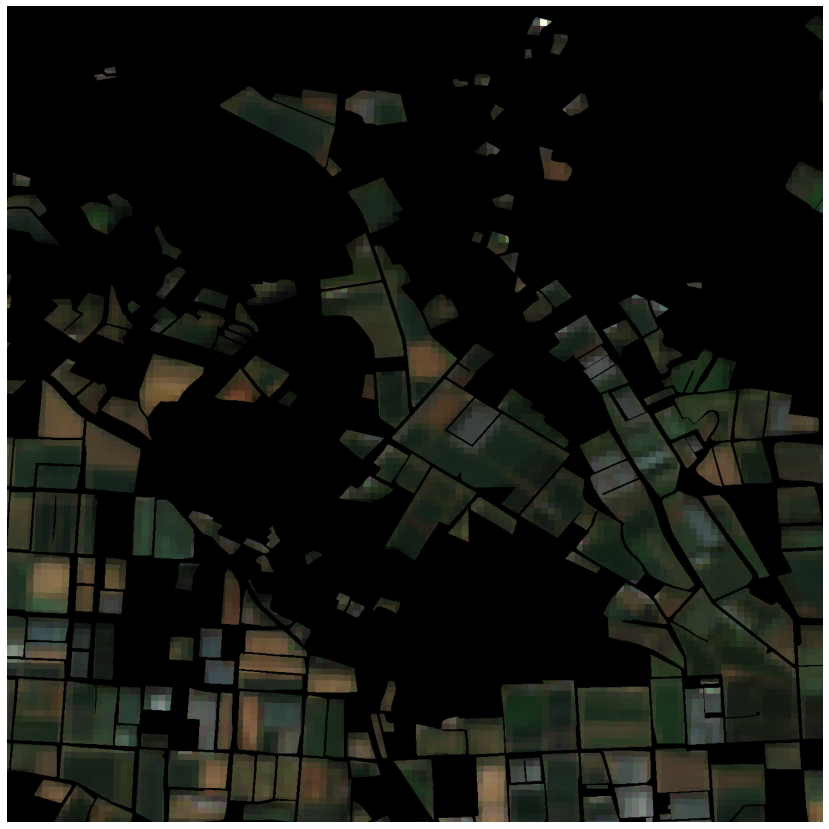

In [29]:
fig, ax = plt.subplots(figsize=(15,15), frameon=False)
ax.imshow(np.transpose(out_image, (1,2,0))/out_image.max())
plt.xticks([])
plt.yticks([])
# plt.Axes(fig, [0., 0., 1., 1.])
plt.axis("off")

fig.savefig("masked_output.png", bbox_inches='tight',transparent=True, pad_inches=0)

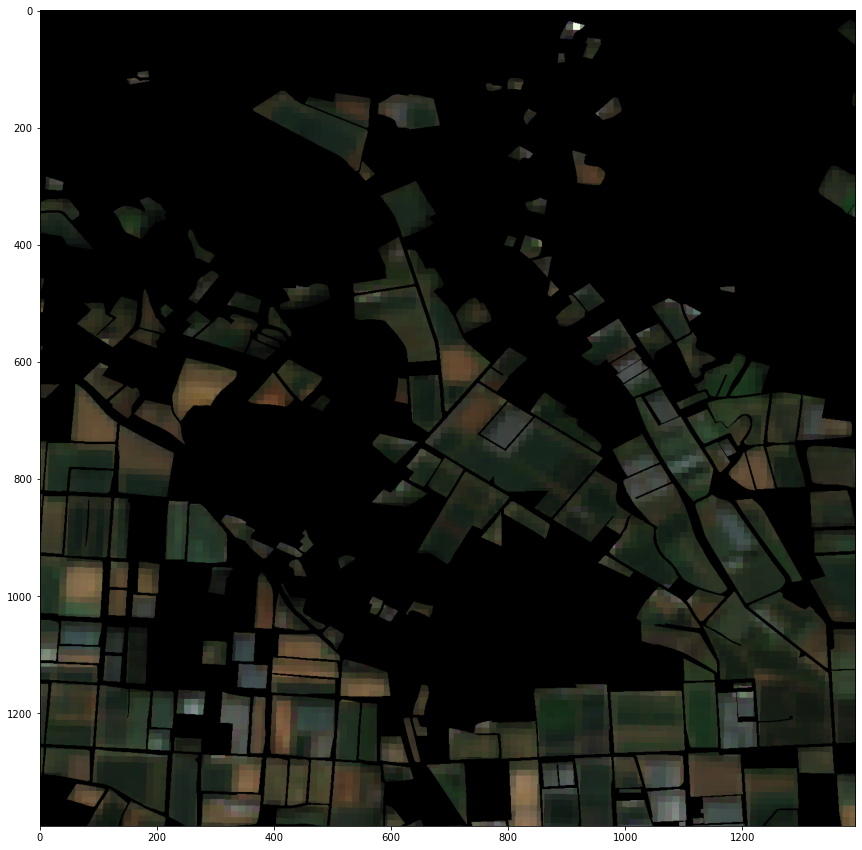

In [197]:
# plot shape on tif image
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(np.transpose(out_image, (1,2,0))/np.max(out_image))

In [176]:
np.max(out_image)

0.0

In [114]:
geom_df["geometry"]

0        POLYGON ((137.47847 34.73469, 137.47847 34.734...
1        POLYGON ((137.48510 34.68240, 137.48512 34.682...
2        POLYGON ((137.48510 34.68240, 137.48509 34.682...
3        POLYGON ((137.47823 34.73534, 137.47826 34.735...
4        POLYGON ((137.47885 34.73371, 137.47882 34.733...
                               ...                        
67143    POLYGON ((137.40013 34.67960, 137.40004 34.678...
67144    POLYGON ((137.39952 34.68268, 137.39956 34.682...
67145    POLYGON ((137.39601 34.67708, 137.39829 34.677...
67146    POLYGON ((137.46915 34.82434, 137.46918 34.824...
67147    POLYGON ((137.39085 34.67606, 137.39361 34.676...
Name: geometry, Length: 67148, dtype: geometry

In [133]:
# test load individual shapes
with rio.open(tif_data_path) as lidar_dem:
    for farm_geom in geom_df["geometry"]:
        try:
            out_image, out_transform = rasterio.mask.mask(lidar_dem, [farm_geom], crop=True)
            print(out_image.shape)
        except Exception as e:
            continue

(3, 9, 13)
(3, 31, 19)
(3, 19, 15)
(3, 17, 20)
(3, 11, 20)
(3, 16, 13)
(3, 13, 22)
(3, 12, 25)
(3, 11, 41)
(3, 8, 37)
(3, 15, 28)
(3, 11, 33)
(3, 21, 22)
(3, 29, 21)
(3, 24, 23)
(3, 30, 26)
(3, 29, 24)
(3, 27, 40)
(3, 49, 12)
(3, 27, 33)
(3, 24, 31)
(3, 25, 40)
(3, 29, 25)
(3, 32, 27)
(3, 35, 20)
(3, 23, 44)
(3, 35, 28)
(3, 22, 30)
(3, 28, 33)
(3, 48, 15)
(3, 32, 33)
(3, 39, 26)
(3, 36, 41)
(3, 33, 25)
(3, 30, 27)
(3, 28, 35)
(3, 32, 33)
(3, 29, 31)
(3, 18, 41)
(3, 33, 28)
(3, 27, 46)
(3, 33, 24)
(3, 30, 34)
(3, 25, 32)
(3, 34, 37)
(3, 37, 35)
(3, 26, 43)
(3, 48, 24)
(3, 33, 38)
(3, 28, 47)
(3, 38, 47)
(3, 36, 30)
(3, 34, 41)
(3, 35, 39)
(3, 31, 55)
(3, 32, 61)
(3, 29, 37)
(3, 35, 50)
(3, 32, 44)
(3, 12, 101)
(3, 37, 32)
(3, 22, 51)
(3, 45, 24)
(3, 41, 38)
(3, 52, 40)
(3, 35, 40)
(3, 21, 63)
(3, 42, 23)
(3, 24, 46)
(3, 42, 22)
(3, 77, 30)
(3, 38, 61)
(3, 42, 45)
(3, 52, 51)
(3, 34, 51)
(3, 64, 46)
(3, 53, 28)
(3, 21, 51)
(3, 38, 41)
(3, 74, 44)
(3, 36, 42)
(3, 59, 46)
(3, 41, 55)
(3, 4

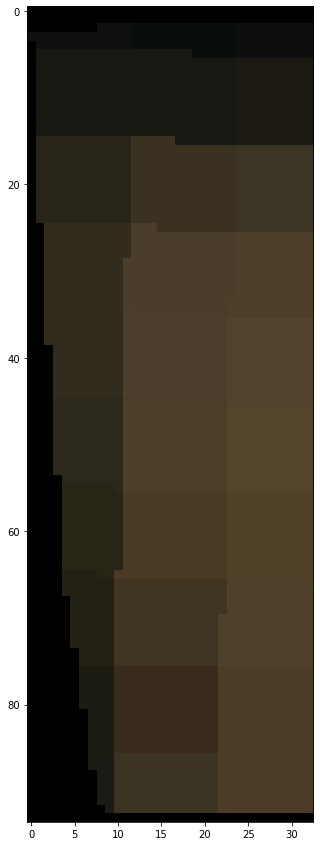

In [126]:
# what a cropped shape looks like in image
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(np.transpose(out_image, (1,2,0)))

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

#### open tif file as image

(3, 1392, 1392)
(1392, 1392, 3)
0.4328


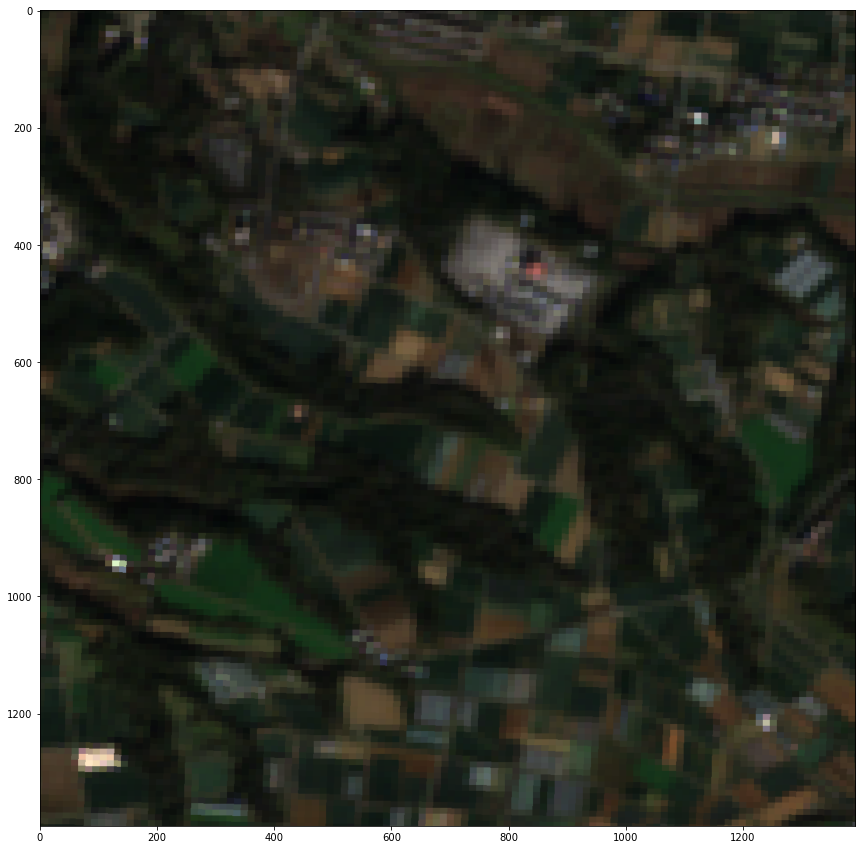

In [175]:
from osgeo import gdal
import numpy as np
ds = gdal.Open('toyohashi_export_full_scale_smaller.tif').ReadAsArray()
print(ds.shape)
# image = np.concatenate([ds[4:5], ds[3:4], ds[2:3]], 0)
image = np.transpose(ds, (1,2,0))
print(image.shape)
print(image.max())
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(image/image.max()) # normalized